In [1]:
import lightkurve as lk
import numpy as np
import pandas as pd
import glob
from astropy.io import ascii
from astropy.table import Table, join, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
from astroquery.mast import Observations, Catalogs
from operator import itemgetter

In [2]:
def plot_sector(tic):
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    for sec in sectors:
        try:
            lcsectorpath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            lcfile = lk.open(lcsectorpath)
            lcfile.scatter()
            plt.title('TIC:{},sector:{}'.format(tic,sec))
        except:
            print('nothing for tic:{} sector:{}'.format(tic,sec))

In [3]:
# unique item finder

def uniquefinder(mylist):
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('there are {} unique tics. Use the first output dictionary'.format(uniques), \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

In [4]:
#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    aa=[]
    bb=[]
    if type(a[0]) != type(b[0]):
        for i in a:
            sa = int(i)
            aa.append(sa)
        for i in b:
            sb = int(i)
            bb.append(sb)
        a = aa
        b = bb
    else:
        a=a
        b=b
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a

In [5]:
def getIndexes(dfObj, value):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
 
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos


# fixing good tic list too

In [57]:
secstats = ascii.read('data/bigstats_by_sector.fits') #og/add/ext tics
allstats = ascii.read('data/bigstats_stitchedlcs.fits')#all acf/ls for all tics
#tics
#cooltics = np.load('data/cool_cvz_tics.npy') #list of old tics
#addtics = np.load('data/additional_cvz_tics.npy') #list of new tics 
alltics = np.load('data/all_dled_tics.npy') # list of new+old tics
goodtics = np.load('data/good_cvz_tics.npy') #only 10+ sectors



#CUTS to data
cvzstats = allstats[allstats['TOTsecs']>=10]
print(len(cvzstats),len(goodtics))
cvzsecs = secstats[secstats['NUMsectors']>=10]
print(len(cvzsecs))

6009 6010
71046


In [58]:
#test if goodtics & cvzstats['ID'] are the exact same (should be)


type(goodtics[0]),type(cvzstats['TOTsecs'][0]),type(cvzsecs['NUMsectors'][0])
len(goodtics)
cvzids = cvzstats['ID']

notin_goods, notin_cvz = returnNotMatches(cvzids,goodtics)
print(len(notin_goods),len(notin_cvz))

# for row in allstats:
#     tic = row['ID']
#     if tic in goodtics:
idss=[]
for idx, i in enumerate(goodtics):
    ids = np.where(allstats['ID']==i)[0]
#     print(ids)
    idss.append(ids)
idxs = np.concatenate(idss)
len(idxs),len(idss)

0 1


(6009, 6010)

In [59]:
print(notin_cvz[0])
# cvzstats[cvzstats['ID']==38877648]#notin_cvz[0]]
cvzstats[cvzstats['ID']==38877693]

38877693


<Table masked=True length=0>
  ID  TOTsecs   rvar    ls1     ls2   ... e_Dec_orig raddflag wdflag objID
int64  int64  float64 float64 float64 ...  float64    int64   int64  int64
----- ------- ------- ------- ------- ... ---------- -------- ------ -----

In [60]:
#removing vallue above

newgoodtics = np.delete(goodtics,np.where(goodtics==38877693))
print(len(goodtics),len(newgoodtics),newgoodtics[newgoodtics==38877693])


#saving new array
# np.save('data/good_cvz_tics.npy',newgoodtics) #already ran

6010 6009 []


# creating table of all stats (by sector, total sectors available, tic catalog)

In [6]:
# tic_list = np.load('data/cool_cvz_tics.npy')
# #target_tics = np.load('data/bad_ticlists/dupes_tics.npy') #this is all camera4
# print(len(target_tics))

In [7]:
#used this in the for loop below - finds index for specific value (like np.where but for pandas)

# def getIndexes(dfObj, value): #enter dataframe, value wanted
#     ''' Get index positions of value in dataframe i.e. dfObj.'''
 
#     listOfPos = list()
#     # Get bool dataframe with True at positions where the given value exists
#     result = dfObj.isin([value])
#     # Get list of columns that contains the value
#     seriesObj = result.any()
#     columnNames = list(seriesObj[seriesObj == True].index)
#     # Iterate over list of columns and fetch the rows indexes where value exists
#     for col in columnNames:
#         rows = list(result[col][result[col] == True].index)
#         for row in rows:
#             listOfPos.append((row, col))
#     # Return a list of tuples indicating the positions of value in the dataframe
#     return listOfPos

# rerun below cell to add to master by sector table AFTER the extras from additions runs the by sector script

In [46]:
#Opening stats from each sector and saving to a table
#tic_list = np.load('data/all_dled_tics.npy')
tic_list = np.load('data/additional_cvz_tics.npy') #list of new tics 
#tic_list = np.load('data/ticadds_needbysector.npy')

ls1=[]
ls2=[]
ls3=[]
tics=[]
rvars=[]
sector=[]
lsamp1=[]
lsamp2=[]
lsamp3=[]
missing=[]
#tic_list=['349309133',123] #used while testing
for tic in tic_list:
    sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
    for sec in sectors:
        try:
            #lcsectorpath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sec)
            #dont want this many plots here but keep incase doing smaller num of tics
#             lcfile = lk.open(lcsectorpath)
#             lcfile.scatter()
#             plt.title('TIC:{},sector:{}'.format(tic,sec))
            statsecpath = 'data/SECONDRUN/cleaned_LightCurves/{}/stats_ADDITIONS.csv'.format(tic)
            stats = pd.read_csv(statsecpath)
            #print(stats)
            ix = getIndexes(stats,sec)
            #print('ix:',ix,'mysector:',sec)
            idx = ix[0][0] #gets row index for that sectors row data
            #print('index:',idx)
            lsrp1 = stats.iloc[idx,2]
            ls1amp = stats.iloc[idx,5]
            lsrp2= stats.iloc[idx,3]
            ls2amp = stats.iloc[idx,6]
            lsrp3= stats.iloc[idx,4]
            ls3amp = stats.iloc[idx,7]
            rvar = stats.iloc[idx,1] 
            sect = stats.iloc[idx,0]
            ls1.append(lsrp1)
            ls2.append(lsrp2)
            ls3.append(lsrp3)
            lsamp1.append(ls1amp)
            lsamp2.append(ls2amp)
            lsamp3.append(ls3amp)
            tics.append(tic)
            rvars.append(rvar)
            sector.append(sect)
        except:
            #print('nothing for sector:',sec)
            missing.append(tic)
            continue
        #break
print('ls:',len(ls1))
print(len(tic_list),len(tics))
print('lsmap:',len(lsamp1))
print(len(missing))#,missing)

ls: 14820
1457 14820
lsmap: 14820
4121


## note that for above cell all files (originals & extras) named stats.csv expect for 'additions' those were named stats_ADDITIONS.csv

In [112]:
# seen, uniq_missing = uniquefinder(missing) #tics)
# len(seen),len(uniq_missing)

In [113]:
#1095,1253,1457
# notin_missing , notin_tics = returnNotMatches(uniq_tics,uniq_missing)
# len(notin_missing) , len(notin_tics)

In [111]:
# notin_tics

In [109]:
#YES REMOVED TIC 38877693 B/C TYPE TessTargetPixelFile

#might need to remove tic 38877693 from additonals list b/c its a TessTargetPixelFile
# change = lk.open('data/Added_LightCurves/tess2018206045859-s0001-0000000038877693-0120-s_lc.fits')
# change.scatter()

In [108]:
#these tics were exceptions to the additional tics ********* they didnt run the by sector script**********
# notin_uniq , notin_adds = returnNotMatches(addtics,uniq)
# #np.save('data/ticadds_needbysector',notin_uniq) #already saved
# len(notin_uniq) , len(notin_adds)#, notin_uniq #,len(tics),len(uniq)

In [101]:
# seen, uniq = uniquefinder(missing)
# len(seen),len(uniq),len(missing),len(tic_list)-len(uniq)

In [102]:
# notin_unique , notin_ticlist = returnNotMatches(tics,uniq)
# len(notin_unique) , len(notin_ticlist),len(tics),len(uniq)

In [103]:
# addtics = np.load('data/additional_cvz_tics.npy') #list of new tics 
# len(addtics),type(addtics[0]),type(uniq[0])
# type(tics[0]),type(uniq[0])
# for i in uniq:
#     ii = int(i)
#     #print(type(ii))
#     if ii == 117935303:
#         print(i)

In [104]:
#tic = tic_list#uniq[0]
#print(tic)
# start = 0
# ticsnosec=[]
# for tic in tic_list:
    
#     #statsecpath = 'data/SECONDRUN/cleaned_LightCurves/{}/stats.csv'.format(tic)
#     path = 'data/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)
#     try:
# #         stats = pd.read_csv(statsecpath)
# #         print(tic,stats)
#         mytest = fits.open(path)
#         #print(tic)
#         ticsnosec.append(tic)
#         start += 1
#         mytest.close()
#     except:
#         continue
# start,len(tic_list),len(addtics),len(ticsnosec)

In [105]:
# notin_start , notin_adds = returnNotMatches(addtics,ticsnosec)
# len(notin_start) , len(notin_adds) #,len(tics),len(uniq)

In [106]:
# notin_start #these added tics have (uncleaned)lcs but cleaning & calcs per sector script didnt work on them

In [107]:
#FOUND MISTAKE...STATS.CSV IS NAMED STATS_ADDITIONS.CSV SO THATS WHY THEY DIDNT SHOW UP INITIALLY

# for tic in notin_start:
#     sectors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
#     for sec in sectors:
#         path = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sector)
        

In [44]:
#creating stats by sectors table
#stat_table_extras = Table([tics,sector,rvars,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3],names=('ID','sector','rvar','ls1','ls2','ls3','lsamp1','lsamp2','lsamp3'))
#ascii.write(stat_table_extras,'data/statstable_by_sector_EXTRAS.dat') #already ran

In [49]:
#creating stats by sectors table
# stat_table_additons = Table([tics,sector,rvars,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3],names=('ID','sector','rvar','ls1','ls2','ls3','lsamp1','lsamp2','lsamp3'))
# ascii.write(stat_table_additons,'data/statstable_by_sector_ADDITIONS.dat') #ran already

# finish below - add totnum sectors, combine additons & extras then merge to big stats table

##### this section opens stats for additions & extras data BY SECTOR

In [8]:
#openign tables fro addtions and extras

addtable = ascii.read('data/SECONDRUN/old_runs/statstable_by_sector_ADDITIONS.dat')
extratable = ascii.read('data/SECONDRUN/old_runs/statstable_by_sector_EXTRAS.dat')
newtable = vstack([extratable,addtable])
print(len(addtable),len(extratable),len(newtable), len(addtable)+len(extratable))
len(newtable),type(newtable),type(addtable),type(extratable) #17169


# print(len(addtable),len(extratable),len(newadds), len(addtable)+len(extratable))
#len(newadds),type(newadds),type(addtable),type(extratable) #17169


14820 2349 17169 17169


(17169,
 astropy.table.table.Table,
 astropy.table.table.Table,
 astropy.table.table.Table)

In [9]:
print(newtable)
newtable

    ID    sector ...         lsamp2                lsamp3       
--------- ------ ... --------------------- ---------------------
 38877648      1 ...  0.015230123468919231  0.011912596306472921
 38877648      2 ...  0.006462432150597678  0.005303395376209413
 38877648      3 ...  0.027750102469489956  0.022939051801577924
 38877648      4 ...  0.024921874145871468    0.0237141592142052
 38877648      6 ...  0.012423143106670616  0.007659851648707022
 38877648      7 ...  0.020086645636555624 0.0077379299425039735
 38877648      8 ...  0.026933544341715642  0.018850027732744055
 38877648      9 ... 0.0065540188113046354 0.0061367856391912855
 38877648     10 ...  0.010996560214612096  0.010591017214475123
 38877648     11 ...  0.004096245636460549  0.002564829888718404
      ...    ... ...                   ...                   ...
382159806     13 ...   0.00180016601391457 0.0017691133822090586
388131734      4 ...    0.2880497952912468    0.1040390573183694
388131734      5 ...   0.

<Table length=17169>
    ID    sector ...         lsamp2                lsamp3       
  int64   int64  ...        float64               float64       
--------- ------ ... --------------------- ---------------------
 38877648      1 ...  0.015230123468919231  0.011912596306472921
 38877648      2 ...  0.006462432150597678  0.005303395376209413
 38877648      3 ...  0.027750102469489956  0.022939051801577924
 38877648      4 ...  0.024921874145871468    0.0237141592142052
 38877648      6 ...  0.012423143106670616  0.007659851648707022
 38877648      7 ...  0.020086645636555624 0.0077379299425039735
 38877648      8 ...  0.026933544341715642  0.018850027732744055
 38877648      9 ... 0.0065540188113046354 0.0061367856391912855
 38877648     10 ...  0.010996560214612096  0.010591017214475123
 38877648     11 ...  0.004096245636460549  0.002564829888718404
      ...    ... ...                   ...                   ...
388131734      4 ...    0.2880497952912468    0.1040390573183694
388131734      5 ...   0.22497234865402074     0.067013342195034
388131734      6 ...    0.0353358937874444   0.03515771618590655
388131734      7 ...    0.2641095274012569   0.09836233282790544
388131734      8 ...    0.3707445326463815   0.10124123973644934
388131734      9 ...   0.16449686306829078   0.08384825759872051
388131734     10 ...    0.3120357970430729    0.1718275471578408
388131734     11 ...    0.2758153803528254    0.1604440981452746
388131734     12 ...    0.0868034776475309   0.04962533107815982
388131734     13 ...     0.383804571161651   0.04409120526807818

In [10]:
addtable.colnames,extratable.colnames

(['ID', 'sector', 'rvar', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3'],
 ['ID', 'sector', 'rvar', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3'])

##### this section opens data for additons & extras WITH TOTAL NUMBER OF SECTORS data

In [11]:
#adding totnum sectors to ADDITIONS & EXTRAS ⁨⁩ 
additions = pd.read_csv('data/THIRDRUN/saved_indataas_bigstats_stitchedlcs/files_savedin_big_stats_stitchedlcs/numofsectors_ADDITIONS.csv')
extras = pd.read_csv('data/THIRDRUN/saved_indataas_bigstats_stitchedlcs/numofsectors_extras.csv')
# extras = pd.read_csv('data/THIRDRUN/⁨files_savedin_big_stats_stitchedlcs⁩/numofsectors_extras.csv')
# 1457, 204 #extras is in addtions with wrong values, need to replace from extras
#atics = pd.concat([additions,extras]) #cant do b/c extras tics are in additons but with 0 for totnumsectors
print(len(additions),len(extras))#,len(atics),len(additions)+len(extras))


1457 204


In [12]:
#uses pandas --- too time consuming jsut using numpy below this
# row = extras[extras['IDS']==38877648] #, additions[additions['IDS']==38877648]
# test = int(row['NUMsectors'].values)
# type(test),test
# for row in additions.to_numpy():
#     tic = row[0]
#     tot = row[1]
#     newtotrow = extras[extras['IDS']==tic]
#     newtot = int(newtotrow['NUMsectors'].values)
 
#numpy usage
nadditions = additions.to_numpy()
nextras = extras.to_numpy()
newadds = []
for row in nadditions:
    tic = row[0]
    tot = row[1]
    edata = nextras[nextras[::,0]==tic]
    if len(edata) !=0:
        etic = edata[0][0]
        etot = edata[0][1]
        if tic == etic:
            newadds.append((tic,etot))
        else:
            print('do i ever go here')
    else:
        newadds.append((tic,tot))
addtots = list(map(itemgetter(1), newadds)) #grabs 2nd value within this list of lists
addtics = list(map(itemgetter(0), newadds))
sectable = Table([addtics,addtots],names=('ID','NUMsectors'))
sectable

<Table length=1457>
    ID    NUMsectors
  int64     int64   
--------- ----------
 25078674         13
 25081173         12
 25117273         13
 25132314         12
 25133286         13
 25153007         12
 25155664         12
 25196356         13
 29759800         13
 29779053         12
      ...        ...
350824806         10
358112997         10
370040241         10
374944608         10
374997308         10
375056762         10
381975024         10
382101389         10
382159806         10
388131734         10

In [16]:
print(np.where(sectable['NUMsectors']==0)[0][0])
sectable[sectable['NUMsectors']==0] #38877693 really has NO sectors tho

103


<Table length=1>
   ID    NUMsectors
 int64     int64   
-------- ----------
38877693          0

In [17]:
#removing that bad tic 
# sectable.remove_row(np.where(sectable['NUMsectors']==0)[0][0]) #already ran
print(np.where(sectable['NUMsectors']==0))



(array([], dtype=int64),)


In [90]:
# TEST = atics.to_numpy()
# ticstoadd = TEST[::,0]
# totnumsecadd = TEST[::,1]
# sectable = Table([ticstoadd,totnumsecadd],names=('ID','NUMsectors'))
# len(sectable)
# sectable

##### merging additions/extras stats data by sector WITH data about total num of sectors

In [ ]:
#merging in a new way than below b/c that overwrote 0 secs

In [20]:
np.shape(sectable),np.shape(newtable)

((1456,), (17169,))

In [21]:
#merging data to one final table to add
addtable = join(sectable,newtable,keys='ID') #19518
addids = addtable['ID']
seen, uniq_addids = uniquefinder(addids) #tics)
print(len(addtable),len(sectable),len(newtable),len(sectable)+len(newtable))
len(seen),len(uniq_addids)

# len(addtable[np.isnan(addtable['sector'])])

there are 1456 unique tics. Use the first output dictionary to see number of occurances for duplicates
17169 1456 17169 18625


(1456, 1456)

In [25]:
print(np.where(addtable['NUMsectors']==0)) #none so thats good!
addtable

(array([], dtype=int64),)


<Table length=17169>
    ID    NUMsectors sector ...         lsamp2                lsamp3       
  int64     int64    int64  ...        float64               float64       
--------- ---------- ------ ... --------------------- ---------------------
 25063396         11      7 ... 0.0005737058498649988 0.0005552574312625663
 25063396         11      6 ...  0.001440625709868406 0.0008472530521702419
 25063396         11      3 ... 0.0007389849959742683 0.0005990017668270527
 25063396         11      9 ... 0.0016565214307909279 0.0016109328480853526
 25063396         11     10 ...  0.001364099408610421  0.000871283792001214
 25063396         11     11 ... 0.0024908245697510857  0.001900510385626816
 25063396         11     12 ... 0.0008693281996635994 0.0008564284078863211
 25063396         11     13 ... 0.0012317801947841602 0.0011007872033757305
 25063396         11      2 ... 0.0019202355869264878 0.0018658653101026933
 25063396         11      5 ...  0.002753800256569655  0.002415897656501078
      ...        ...    ... ...                   ...                   ...
471015740         12     11 ...   0.08321653011417159  0.057539599735943865
471015740         12     10 ...  0.022360388707983923  0.007743396955807277
471015740         12      9 ...  0.007570440974247197  0.007443491950022706
471015740         12      6 ...  0.006300073711055979  0.005469313692642743
471015740         12      5 ...   0.01177159402440693  0.010262071020017744
471015740         12      4 ...   0.04425964358624684   0.03966815620076157
471015740         12      2 ...  0.004856283508964178   0.00400774946208445
471015740         12      1 ...  0.011145545790195069   0.00939940752790774
471015740         12      8 ...   0.03068300384456147  0.026100566178492383
471015740         12      3 ...  0.062162187150877825   0.05252252492472682

##### opening & merging data from tic table to add to table with additons/extras stats by sec with tot num of secs

In [26]:
#addtable[addtable['ID']==sectable['ID'][1456]]

#adding tic catalog to additions table

tictable = ascii.read('data/tic_table.fits')
#sanity check worked - verified additions are already in tic catalog-noastroquery needed
# notin_ticcat , notin_addtics = returnNotMatches(uniq_addids,tictable['ID'])
# len(notin_ticcat) , len(notin_addtics)
alladditionstable = join(addtable,tictable)
print(len(alladditionstable),len(addtable),len(tictable))
alladditionstable

17169 17169 29824


<Table masked=True length=17169>
    ID    NUMsectors sector          rvar         ... raddflag wdflag   objID  
  int64     int64    int64         float64        ...  int64   int64    int64  
--------- ---------- ------ --------------------- ... -------- ------ ---------
 25063396         11      7    0.0026706963777543 ...        1      0 523671670
 25063396         11      6 0.0026600629091263484 ...        1      0 523671670
 25063396         11      4  0.002794313430786177 ...        1      0 523671670
 25063396         11      5 0.0027641177177428755 ...        1      0 523671670
 25063396         11      2  0.002592253684997492 ...        1      0 523671670
 25063396         11     13  0.002671071887016208 ...        1      0 523671670
 25063396         11      3 0.0025407940149306807 ...        1      0 523671670
 25063396         11     11  0.002789044380188121 ...        1      0 523671670
 25063396         11     10 0.0027387648820877963 ...        1      0 523671670
 25063396         11      9 0.0026883482933044434 ...        1      0 523671670
      ...        ...    ...                   ... ...      ...    ...       ...
471015740         12     11  0.014200815558433557 ...        1      0 529487153
471015740         12     10  0.011552000045776391 ...        1      0 529487153
471015740         12      9  0.011127763986587548 ...        1      0 529487153
471015740         12      6   0.00953298807144165 ...        1      0 529487153
471015740         12      5  0.010006073117255987 ...        1      0 529487153
471015740         12      4  0.011783874034881459 ...        1      0 529487153
471015740         12      2  0.011010393500328064 ...        1      0 529487153
471015740         12      1  0.013882696628570446 ...        1      0 529487153
471015740         12      8   0.01004740595817566 ...        1      0 529487153
471015740         12      3    0.0328553318977356 ...        1      0 529487153

In [27]:
alladditionstable[alladditionstable['NUMsectors']==0]

<Table masked=True length=0>
  ID  NUMsectors sector   rvar    ls1   ... e_Dec_orig raddflag wdflag objID
int64   int64    int64  float64 float64 ...  float64    int64   int64  int64
----- ---------- ------ ------- ------- ... ---------- -------- ------ -----

##### opening old big stats table

In [29]:
#stats by sector ALREADY has addtions/extras!!

#old stat table by sector MISSING addtions & extras
# oldtable = ascii.read('data/bigstats_by_sector.fits')
# oldtable[oldtable['ID']==sectable['ID'][0]] #this table already includes the additons/extras!!

<Table masked=True length=13>
   ID    NUMsectors sector          rvar         ... raddflag wdflag   objID  
 int64     int64    int64         float64        ...  int64   int64    int64  
-------- ---------- ------ --------------------- ... -------- ------ ---------
25078674         13      9 0.0006975054740905318 ...        1      0 523674132
25078674         13      2 0.0006235033273696011 ...        1      0 523674132
25078674         13     10 0.0006929159164429378 ...        1      0 523674132
25078674         13     13 0.0007182419300079124 ...        1      0 523674132
25078674         13      8 0.0008251011371613881 ...        1      0 523674132
25078674         13      7 0.0006947517395019531 ...        1      0 523674132
25078674         13     11  0.000786125659942627 ...        1      0 523674132
25078674         13     12  0.000715088844299383 ...        1      0 523674132
25078674         13      6 0.0007082939147948776 ...        1      0 523674132
25078674         13      5 0.0007405996322630283 ...        1      0 523674132
25078674         13      4 0.0008012175559997116 ...        1      0 523674132
25078674         13      3 0.0005982518196105957 ...        1      0 523674132
25078674         13      1 0.0006382614374159656 ...        1      0 523674132

##### merging old big stats table with new big stats from additions/extras

In [133]:
#already merged

#merging tables
# newest_bysector = vstack([oldtable,alladditionstable])
# print(len(newest_bysector),len(oldtable),len(alladditionstable),len(oldtable)+len(alladditionstable))
#112400 95231 17169 112400 -- soo all good, merged well

112400 95231 17169 112400


In [135]:
#already merged


# finaltics = newest_bysector['ID']
# dltics = np.load('data/all_dled_tics.npy')
# notin_dl , notin_finaltics = returnNotMatches(finaltics,dltics)
# len(notin_dl) , len(notin_finaltics)

(0, 1)

In [138]:
#already merged


#saving table by sector - finally good has extras, orginials & additions
#ascii.write(newest_bysector,'data/bigstats_by_sector.fits') #already ran with overwrite =True to override old table above

In [ ]:
#already merged


# mytest = ascii.read('data/bigstats_by_sector.fits')
# mytest

In [136]:
#already merged


#need to delete this
# notin_finaltics #[38877693]

[38877693]

In [149]:
#already merged


# np.where(dltics==notin_finaltics[0])
# #int(dltics[0]),type(notin_finaltics[0])
# for idx,i in enumerate(dltics):
#     ii = int(i)
#     if ii == notin_finaltics[0]:
#         print(idx)
#     else:
#         continue
# dltics[22732]

22732


/Users/helenfellow/Desktop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


'38877693'

#### merging num of sectors for addtions/extras into big stats table W/O num of sectors info -FOR STITCHED LCS

In [46]:
sectable #additons/extras totnum secs info
allstats = Table.read('data/bigstats_stitchedlcs.fits')#all acf/ls for all tics

newticorder = []
newtotsecs = []
for row in allstats:
    tic = row['ID']
    numsec = row['TOTsecs']
    if tic in sectable['ID']:
        secrow = sectable[sectable['ID']==tic]
        tic = int(secrow['ID'])
        numsec = int(secrow['NUMsectors'])
    newtotsecs.append(numsec)
    newticorder.append(tic)
len(allstats),len(newticorder),len(newtotsecs),len(sectable)

(24087, 24087, 24087, 1456)

In [48]:
# for idx,tic1 in enumerate(allstats['ID']):
#     tic2 = newticorder[idx]
#     if tic1 != tic2:
#         print(tic1,tic2)
testtable = Table([allstats['ID'],newticorder,allstats['TOTsecs'],newtotsecs],names=('ogID','newID','ogNUMsec','newNUMsec'))
testtable[testtable['ogNUMsec']==0] #correctly got new nums

<Table masked=True length=203>
   ogID     newID   ogNUMsec newNUIMsec
  int64     int64    int64     int64   
--------- --------- -------- ----------
 38877648  38877648        0         12
260004324 260004324        0         12
260004559 260004559        0         11
260005298 260005298        0         11
260005509 260005509        0         12
260045375 260045375        0         10
260045558 260045558        0         12
260046328 260046328        0         13
260046359 260046359        0         13
260046469 260046469        0         12
      ...       ...      ...        ...
382268257 382268257        0         13
382303540 382303540        0         10
388202207 388202207        0         13
391948885 391948885        0         11
391948920 391948920        0         11
391949117 391949117        0         10
391950805 391950805        0         11
392009873 392009873        0         10
392011927 392011927        0         12
392011985 392011985        0         12

In [51]:
#rewriting column data 

# allstats['TOTsecs'] = newtotsecs #already ran

In [53]:
#checking against a prior 0 for totsecs
allstats[allstats['ID']==388202207] #verifying worked correctly

<Table masked=True length=1>
    ID    TOTsecs         rvar        ... raddflag wdflag   objID  
  int64    int64        float64       ...  int64   int64    int64  
--------- ------- ------------------- ... -------- ------ ---------
388202207      13 0.00866832733154288 ...        1      0 569327943

In [54]:
#writing to file

# ascii.write(allstats,'data/bigstats_stitchedlcs.fits') #already ran

In [56]:
#testing worked 
allstats = ascii.read('data/bigstats_stitchedlcs.fits')#all acf/ls for all tics

# FIXED THIS PROBLEM!!!

# deleteled this TIC from list - tarpixfile

In [150]:
dltics[dltics[22732]]

'38877693'

In [153]:
#newdltics = np.delete(dltics, [22732], None) already ran

In [154]:
len(dltics),len(newdltics)

(24086, 24085)

In [155]:
#saving---already ran
#np.save('data/all_dled_tics.npy',newdltics)

In [158]:
testload = np.load('data/all_dled_tics.npy')
len(testload),testload

(24085, array(['117935303', '118010415', '118053599', ..., '382101389',
        '382159806', '388131734'], dtype='<U21'))

In [94]:
# #creating table of total number of available sectors per tic
# totsecs = pd.read_csv('data/THIRDRUN/numofsectors.csv')
# ticids = np.array(totsecs['IDS'])
# numsecs = np.array(totsecs['NUMsectors'])
# sectable = Table([ticids,numsecs],names=('ID','NUMsectors'))
# #print(ticids)
# sectable

In [95]:
# #opening stats by sectors table
# stats = ascii.read('data/statstable_by_sector.dat') #note deleted this & just save teh big stat table below
# stats

In [96]:
# #adding tables
# midt = join(sectable,stats)
# print(len(midt),len(stats),len(sectable))
# midt

In [97]:
# #to combine tics need to be strings
# sID=[]
# for i in midt['ID']:
#     i = str(i)
#     sID.append(i)
# midt['ID'] = sID
# midt

In [73]:
# #adding temps & tic catalog stuff
# tictable = Table.read('data/tic_table.fits') #tic catalog for teffs
# bigt = join(midt,tictable)#,keys='ID')
# print(len(tictable),len(midt),len(bigt))
# bigt

# #ascii.write(bigt,'data/bigstats_by_sector.fits')

# subselecting data

In [64]:
#open all data combined above
allstats = ascii.read('data/bigstats_by_sector.fits')
print('this is all the data from target_lists_by_sectors AND stats_by_sector AND tic catalog AND total number of available sectors')
len(allstats),allstats.colnames

this is all the data from target_lists_by_sectors AND stats_by_sector AND tic catalog AND total number of available sectors


(95231,
 ['ID',
  'NUMsectors',
  'sector',
  'rvar',
  'ls1',
  'ls2',
  'ls3',
  'lsamp1',
  'lsamp2',
  'lsamp3',
  'version',
  'HIP',
  'TYC',
  'UCAC',
  'TWOMASS',
  'SDSS',
  'ALLWISE',
  'GAIA',
  'APASS',
  'KIC',
  'objType',
  'typeSrc',
  'ra',
  'dec',
  'POSflag',
  'pmRA',
  'e_pmRA',
  'pmDEC',
  'e_pmDEC',
  'PMflag',
  'plx',
  'e_plx',
  'PARflag',
  'gallong',
  'gallat',
  'eclong',
  'eclat',
  'Bmag',
  'e_Bmag',
  'Vmag',
  'e_Vmag',
  'umag',
  'e_umag',
  'gmag',
  'e_gmag',
  'rmag',
  'e_rmag',
  'imag',
  'e_imag',
  'zmag',
  'e_zmag',
  'Jmag',
  'e_Jmag',
  'Hmag',
  'e_Hmag',
  'Kmag',
  'e_Kmag',
  'TWOMflag',
  'prox',
  'w1mag',
  'e_w1mag',
  'w2mag',
  'e_w2mag',
  'w3mag',
  'e_w3mag',
  'w4mag',
  'e_w4mag',
  'GAIAmag',
  'e_GAIAmag',
  'Tmag',
  'e_Tmag',
  'TESSflag',
  'SPFlag',
  'Teff',
  'e_Teff',
  'logg',
  'e_logg',
  'MH',
  'e_MH',
  'rad',
  'e_rad',
  'mass',
  'e_mass',
  'rho',
  'e_rho',
  'lumclass',
  'lum',
  'e_lum',
  'd',


In [69]:
addtable

<Table length=247899>
    ID    TOTALsectors CAMERA  CCD    Tmag  RA_target DEC_target
  int64      int64     int64  int64 float64  float64   float64  
--------- ------------ ------ ----- ------- --------- ----------
  8195886            1      1     1    9.85  311.3326   -38.4275
  8196058            1      1     1    8.18  311.3688   -38.0655
  8196173            1      1     1    8.99  311.4127   -37.8439
  8196285            1      1     1    9.08   311.356   -37.5918
  8196324            1      1     1    9.39  311.3043   -37.5068
  8196402            1      1     1    9.97  311.4088   -37.3279
 24195569            1      1     4   12.75  317.9844   -22.8767
 24195690            1      1     4    9.41  318.0197   -22.5439
 24231627            1      1     4    9.64  318.1267   -23.4428
 24265684            1      1     4    7.49  318.3628   -22.5463
      ...          ...    ...   ...     ...       ...        ...
471012714            3      3     4   12.57   38.7177   -82.0725
471013528            1      2     3   15.46  299.0543   -58.3469
471013535            2      2     1    15.6  266.5646   -70.6394
471013553           10      4     1    15.8   85.8925   -68.3728
471013569            1      1     1    15.9  266.9455   -52.1197
471013582           12      4     2    16.1   91.1287   -71.4231
471015190           10      4     2   10.59    95.995    -68.485
471015740           12      4     4   10.33     73.99   -61.1628
471016408            1      2     3   10.13   293.652   -62.8441
471016524            2      3     1   12.46  355.5101   -78.6896

In [75]:
#seeing how many of 13, 12 ,11,10 sectors in the new additions
addtics = np.load('data/additional_cvz_tics.npy')
addtable = ascii.read('data/targets_by_sector.fits')
#len(addtable),len(addtics),len(addtable)
# sectors = []
# for i in addtable['NUMsectors']:
#     sectors.append(i)
# for i in sectors:
#     si = str(i)


seen={}
add13=[]
add12=[]
add11=[]
add10=[]
for row in addtable:
    tic = row['ID']
    for i in addtics:
        if tic == i:
            sec = row['TOTALsectors']
            if tic not in seen:
                seen[tic] = sec
                if sec == 13:
                    add13.append(sec)
                if sec == 12:
                    add12.append(sec)
                if sec == 11:
                    add11.append(sec)
                if sec == 10:
                    add10.append(sec)
        else:
            continue
# sum13 = np.sum(add13)
# sum12 = np.sum(add12)
# sum11 = np.sum(add11)
# sum10 = np.sum(add10)
print('13:',len(add13),'  12:',len(add12),'  11:',len(add11),'  10:',len(add10))

13: 421   12: 525   11: 303   10: 208


In [25]:
#isolating tics with 10+sectors available


#chooseing only those with more than 10 sectors available from mine & target tables
above10_mine = allstats[allstats['NUMsectors'] >=10]

#target list for all sectors table
target_table = ascii.read('data/targets_by_sector.fits') #this is data for ENTIRE target list for S.Hemisphere
above10_target = target_table[target_table['TOTALsectors'] >=10]

#finding teh uniques-mine#############################
tics_mine = above10_mine['ID']
dup_mine, unik_mine  = uniquefinder(tics_mine)
#finding teh uniques-target###########################
tics_target = above10_target['ID']
dup_target, unik_target  = uniquefinder(tics_target)

#print(len(dup_mine),len(unik_mine),len(above10_mine['ID']),len(dup_target),len(unik_target),len(above10_target['ID']))

there are 4553 unique tics. Use the first output dictionary to see number of occurances for duplicates
there are 6010 unique tics. Use the first output dictionary to see number of occurances for duplicates


In [26]:
#combining those unik tics with target list that had 10 or more sectors

notin_mine, notin_target = returnNotMatches(unik_target, unik_mine)
print(len(notin_mine),len(notin_target))

#adding new tics to my tics
besttics = np.append(unik_mine,notin_mine)
#saving b/c these are good
#np.save('data/good_cvz_tics',besttics) #already ran once

#making sure theyre all unique
dup_best, unik_best  = uniquefinder(besttics)
print(len(dup_best),len(unik_best))

1457 0
there are 6010 unique tics. Use the first output dictionary to see number of occurances for duplicates
6010 6010


In [27]:
#sanity check --- confirms these are new tics i need to add

print(len(tic_list))
dup_ticlist, unik_ticlist  = uniquefinder(tic_list)
print(len(dup_ticlist),len(unik_ticlist))

#print(type(tic_list),type(besttics[0]))
holding=[]
for i in besttics:
    si = str(i)
    holding.append(si)
stringbesttics=np.array(holding)
notin_ticlist, notin_best = returnNotMatches(stringbesttics, tic_list)
print(len(notin_ticlist),len(notin_best))

22629
there are 22629 unique tics. Use the first output dictionary to see number of occurances for duplicates
22629 22629
1457 18076


## writing customcurl download script to dl files for these additional tics with 10+ sectors

In [30]:
mast_file2 = pd.read_csv('data/bad_ticlistsAND_mast/MAST_2020-02-24T0315.csv',skiprows=4)#used ra/dec min n max from printout below with small plot
mast_file2


dataproduct_type  calib_level obs_collection  \
0            timeseries            3           TESS   
1            timeseries            3           TESS   
2            timeseries            3           TESS   
3            timeseries            3           TESS   
4            timeseries            3           TESS   
...                 ...          ...            ...   
105386       timeseries            3           TESS   
105387       timeseries            3           TESS   
105388       timeseries            3           TESS   
105389       timeseries            3           TESS   
105390       timeseries            3           TESS   

                                                   obs_id  target_name  \
0         tess2018263035959-s0003-0000000150440079-0123-s    150440079   
1         tess2018263035959-s0003-0000000150275309-0123-s    150275309   
2         tess2018263035959-s0003-0000000167721057-0123-s    167721057   
3         tess2018263035959-s0003-0000000142082642-0123-s    142082642   
4         tess2018263035959-s0003-0000000141480176-0123-s    141480176   
...                                                   ...          ...   
105386  tess2018206190142-s0001-s0013-0000000261061538...    261061538   
105387  tess2018206190142-s0001-s0013-0000000300560295...    300560295   
105388  tess2018206190142-s0001-s0013-0000000350843192...    350843192   
105389  tess2018206190142-s0001-s0013-0000000350477233...    350477233   
105390  tess2018206190142-s0001-s0013-0000000167123841...    167123841   

              s_ra      s_dec         t_min         t_max  t_exptime  ...  \
0        97.565154 -61.788589  58381.533115  58408.883108        120  ...   
1        95.023504 -63.108301  58381.533115  58408.883108        120  ...   
2       103.312628 -63.900104  58381.533115  58408.883108        120  ...   
3        98.384528 -72.323177  58381.533115  58408.883108        120  ...   
4        86.783622 -74.770244  58381.533115  58408.883108        120  ...   
...            ...        ...           ...           ...        ...  ...   
105386   81.340326 -78.138557  58324.793958  58681.857757        120  ...   
105387  112.915881 -68.133224  58324.792673  58681.856542        120  ...   
105388   90.011238 -59.313495  58324.792246  58681.855940        120  ...   
105389   85.832835 -54.819575  58324.792006  58681.855641        120  ...   
105390   96.301751 -66.486185  58516.840178  58681.856506        120  ...   

       provenance_name                                          s_region  \
0                 SPOC   CIRCLE ICRS 97.56515400 -61.78858900 0.00138889   
1                 SPOC   CIRCLE ICRS 95.02350400 -63.10830100 0.00138889   
2                 SPOC  CIRCLE ICRS 103.31262800 -63.90010400 0.00138889   
3                 SPOC   CIRCLE ICRS 98.38452800 -72.32317700 0.00138889   
4                 SPOC   CIRCLE ICRS 86.78362200 -74.77024400 0.00138889   
...                ...                                               ...   
105386            SPOC   CIRCLE ICRS 81.34032600 -78.13855700 0.00138889   
105387            SPOC  CIRCLE ICRS 112.91588100 -68.13322400 0.00138889   
105388            SPOC   CIRCLE ICRS 90.01123800 -59.31349500 0.00138889   
105389            SPOC   CIRCLE ICRS 85.83283500 -54.81957500 0.00138889   
105390            SPOC   CIRCLE ICRS 96.30175100 -66.48618500 0.00138889   

        jpegURL                                            dataURL  \
0           NaN  mast:TESS/product/tess2018263035959-s0003-0000...   
1           NaN  mast:TESS/product/tess2018263035959-s0003-0000...   
2           NaN  mast:TESS/product/tess2018263035959-s0003-0000...   
3           NaN  mast:TESS/product/tess2018263035959-s0003-0000...   
4           NaN  mast:TESS/product/tess2018263035959-s0003-0000...   
...         ...                                                ...   
105386      NaN  mast:TESS/product/tess2018206190142-s0001-s001...   
105387      NaN  mast:TESS/product/tess2018206190142-s0001-

In [31]:
add_tics = np.load('data/additional_cvz_tics.npy')
ix2=[]
for count,i in enumerate(add_tics):
    shorter = np.where(mast_file2['target_name']==i)
    for arr in shorter:
        for i in arr:
            ix2.append(i)
len(ix2)
mt = mast_file2.iloc[ix2]
#mt.to_csv('data/MAST_foradditions.csv',index=False) #already ran

dec: -55.500299 -77.99592500091799
ra: 359.979475001333 0.0080529993334153


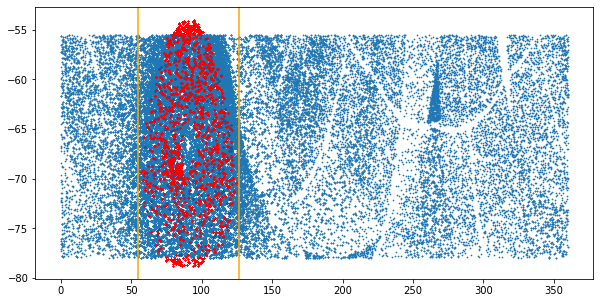

In [19]:
# mast_file = pd.read_csv('data/MAST_2019-09-30T1928.csv',skiprows=4)
# Mra=mast_file['s_ra']
# Mdec=mast_file['s_dec']
# print('dec:',np.max(Mdec),np.min(Mdec))
# print('ra:',np.max(Mra),np.min(Mra))
# plt.figure(figsize=(10,5))
# plt.scatter(Mra,Mdec,s=.5)
# plt.scatter(ra,dec,s=.3,c='r')
# plt.axvline(126.5,c='orange')
# plt.axvline(55,c='orange')
# plt.xlabel('RA',fontsize=20)
# plt.ylabel('DEC',fontsize=20)
# # mast_file


In [9]:
# # sids=[]
# # for i in add_tics:
# #     si = str(i)
# #     sids.append(si)
# add_tics = np.load('data/additional_cvz_tics.npy')
# target_table = ascii.read('data/targets_by_sector.fits')

# y = np.repeat(1,len(add_tics))
# #target_table
# # test = Table([add_tics,])

In [32]:
#isolating target by sector table to only rows with ticids in the new additions list
add_tics = np.load('data/additional_cvz_tics.npy')
ix=[]
for count,i in enumerate(add_tics):
    shorter = np.where(target_table['ID']==i)
    for arr in shorter:
        for i in arr:
            ix.append(i)
#print(len(ix),ix)

dec: -53.9733 -78.8155
ra: 124.0628 57.2586


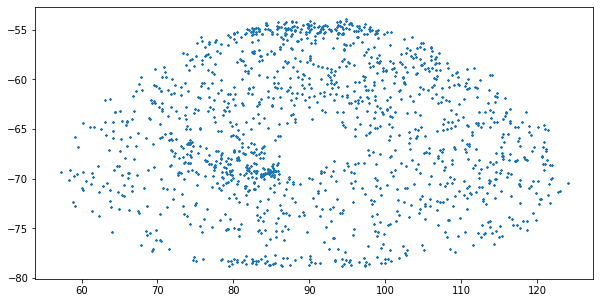

In [33]:
#plotting new additons ra/dec 
short=target_table[ix]   
ra=short['RA_target']
dec=short['DEC_target']
print('dec:',np.max(dec),np.min(dec))
print('ra:',np.max(ra),np.min(ra))
plt.figure(figsize=(10,5))
plt.scatter(ra,dec,s=.5)

dec: -55.500299 -77.99592500091799
ra: 359.979475001333 0.0080529993334153


Text(0, 0.5, 'DEC')

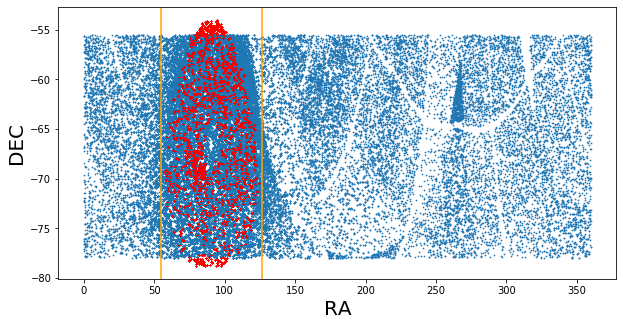

In [34]:
mast_file = pd.read_csv('data/MAST_2019-09-30T1928.csv',skiprows=4)
Mra=mast_file['s_ra']
Mdec=mast_file['s_dec']
print('dec:',np.max(Mdec),np.min(Mdec))
print('ra:',np.max(Mra),np.min(Mra))
plt.figure(figsize=(10,5))
plt.scatter(Mra,Mdec,s=.5)
plt.scatter(ra,dec,s=.3,c='r')
plt.axvline(126.5,c='orange')
plt.axvline(55,c='orange')
plt.xlabel('RA',fontsize=20)
plt.ylabel('DEC',fontsize=20)
# mast_file



In [ ]:
# mast_file = pd.read_csv('data/MAST_2019-09-30T1928.csv',skiprows=4)
# mast_file
# add_tics = np.load('data/additional_cvz_tics.npy')
# for row in short:
#     si = str(row['ID'])
#     ra=row['RA_target']
#     dec=row['DEC_target']
#     #print(si)
# #     obs_table = Catalogs.query_criteria(catalog="Tic",ID=si)
# # #     products = Observations.get_product_list(ID = si)
# #     #break
# # #products
#     obs_table = Observations.query_criteria(obs_collection='TESS',ID=si)
#     break
# obs_table

# actually doing shell script

In [3]:
#this has probs - think i need to do a mast thing first
#see third_exploration notebook for example



#np.save('data/additional_cvz_tics', notin_mine) #already saved
mast_adds = pd.read_csv('data/MAST_foradditions.csv')#,skiprows=4)

#print(len(add_tics))

curlscript = []
for i in range(len(mast_adds)):
    firststr = 'curl -C - -L -o '
    middlestr = str(mast_adds['obs_id'][i]) +'_lc.fits '
    webaddy = "https://mast.stsci.edu/api/v0.1/Download/file/?uri=" 
    laststr = webaddy +str(mast_adds['dataURL'][i])
    script = firststr + middlestr + laststr 
    #print(script)
    curlscript.append(script)
curlscript=np.array(curlscript)
curlscript.shape




(18791,)

In [4]:
# for i in curlscript:
#     print(i)

curl -C - -L -o tess2018263035959-s0003-0000000025078674-0123-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018263035959-s0003-0000000025078674-0123-s_lc.fits
curl -C - -L -o tess2019032160000-s0008-0000000025078674-0136-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019032160000-s0008-0000000025078674-0136-s_lc.fits
curl -C - -L -o tess2018292075959-s0004-0000000025078674-0124-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018292075959-s0004-0000000025078674-0124-s_lc.fits
curl -C - -L -o tess2019006130736-s0007-0000000025078674-0131-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019006130736-s0007-0000000025078674-0131-s_lc.fits
curl -C - -L -o tess2019085135100-s0010-0000000025078674-0140-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019085135100-s0010-0000000025078674-0140-s_lc.fits
curl -C - -L -o

curl -C - -L -o tess2018234235059-s0002-0000000141811261-0121-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018234235059-s0002-0000000141811261-0121-s_lc.fits
curl -C - -L -o tess2019140104343-s0012-0000000141811261-0144-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019140104343-s0012-0000000141811261-0144-s_lc.fits
curl -C - -L -o tess2019169103026-s0013-0000000141811261-0146-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019169103026-s0013-0000000141811261-0146-s_lc.fits
curl -C - -L -o tess2018206190142-s0001-s0013-0000000141811261-00226_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018206190142-s0001-s0013-0000000141811261-00226_dvt.fits
curl -C - -L -o tess2018263035959-s0003-0000000141823020-0123-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018263035959-s0003-0000000141823020-0123-s_lc.fits
curl

curl -C - -L -o tess2019058134432-s0009-0000000260188017-0139-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019058134432-s0009-0000000260188017-0139-s_lc.fits
curl -C - -L -o tess2019112060037-s0011-0000000260188017-0143-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019112060037-s0011-0000000260188017-0143-s_lc.fits
curl -C - -L -o tess2019085135100-s0010-0000000260188017-0140-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019085135100-s0010-0000000260188017-0140-s_lc.fits
curl -C - -L -o tess2018234235059-s0002-0000000260188017-0121-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018234235059-s0002-0000000260188017-0121-s_lc.fits
curl -C - -L -o tess2019140104343-s0012-0000000260188017-0144-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019140104343-s0012-0000000260188017-0144-s_lc.fits
curl -C - -L -o

curl -C - -L -o tess2018263035959-s0003-0000000300654773-0123-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018263035959-s0003-0000000300654773-0123-s_lc.fits
curl -C - -L -o tess2019006130736-s0007-0000000300654773-0131-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019006130736-s0007-0000000300654773-0131-s_lc.fits
curl -C - -L -o tess2018292075959-s0004-0000000300654773-0124-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2018292075959-s0004-0000000300654773-0124-s_lc.fits
curl -C - -L -o tess2019032160000-s0008-0000000300654773-0136-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019032160000-s0008-0000000300654773-0136-s_lc.fits
curl -C - -L -o tess2019058134432-s0009-0000000300654773-0139-s_lc.fits https://mast.stsci.edu/api/v0.1/Download/file/?uri=mast:TESS/product/tess2019058134432-s0009-0000000300654773-0139-s_lc.fits
curl -C - -L -o

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [36]:
# #i actually move to inside "Added_LightCurves" folder so files save to there
''' 
with open ('data/additional_customcurl.sh', 'w') as rsh:
    for count,script in enumerate(curlscript):
        rsh.write('''\
#! /bin/bash
{}
'''.format(script))


'''

## trying to finish downloading by id'ing tics that got skipped when lost internet

In [5]:
mast_adds = pd.read_csv('data/MAST_foradditions.csv')#,skiprows=4)
fns = []
for i in range(len(mast_adds)):
    middlestr = str(mast_adds['obs_id'][i]) +'_lc.fits'
    fns.append(middlestr)

In [6]:
nodl=[]
errs=[]
for i in fns:
    path = 'data/Added_LightCurves/' + i
#     lc = lk.open(path)
#     if type(lc) == 'lightkurve.lightcurvefile.TessLightCurveFile':
#         continue
#     else:
#         errs.append(i)
    #print(path,type(path))
    
    try:
        lk.open(path)
    except FileNotFoundError:
        nodl.append(i)
    except ValueError:
        errs.append(i)
print(len(errs),len(fns))

1566 18791


In [7]:
print(len(errs),len(fns),len(nodl))

1566 18791 2484


## writing 2nd dl script for additional tics

In [37]:
#getting a list of tics from nodl in order to shorten mast table to gather needed data
idxs=[]
for i in nodl:
    obs_id = i[:-8]
    for count,item in enumerate(mast_adds['obs_id']):
        if obs_id == item:
            #print(count,'next')
            #idx = mast_adds['target_name']
            idx = count
            idxs.append(idx)
           # print(idxs)
    #print('going back')
print(len(idxs))

2484


In [41]:
#downselecting the addtions mast table to only files that were skipped
print(np.shape(idxs),type(mast_adds))
skipped_mast = mast_adds.iloc[idxs]
skipped_mast

(2484,) <class 'pandas.core.frame.DataFrame'>


dataproduct_type  calib_level obs_collection  \
11063       timeseries            3           TESS   
11064       timeseries            3           TESS   
11065       timeseries            3           TESS   
11066       timeseries            3           TESS   
11067       timeseries            3           TESS   
...                ...          ...            ...   
13542       timeseries            3           TESS   
13543       timeseries            3           TESS   
13544       timeseries            3           TESS   
13545       timeseries            3           TESS   
13546       timeseries            3           TESS   

                                                obs_id  target_name  \
11063  tess2019112060037-s0011-0000000300744369-0143-s    300744369   
11064  tess2019140104343-s0012-0000000300744369-0144-s    300744369   
11065  tess2019169103026-s0013-0000000300744369-0146-s    300744369   
11066  tess2018206045859-s0001-0000000300744369-0120-s    300744369   
11067  tess2018234235059-s0002-0000000300744369-0121-s    300744369   
...                                                ...          ...   
13542  tess2018263035959-s0003-0000000350708370-0123-s    350708370   
13543  tess2018349182459-s0006-0000000350708370-0126-s    350708370   
13544  tess2019032160000-s0008-0000000350708370-0136-s    350708370   
13545  tess2019058134432-s0009-0000000350708370-0139-s    350708370   
13546  tess2018206045859-s0001-0000000350708370-0120-s    350708370   

             s_ra      s_dec         t_min         t_max  t_exptime  ...  \
11063  116.502719 -69.497955  58596.270522  58623.391344        120  ...   
11064  116.502719 -69.497955  58624.448288  58652.391332        120  ...   
11065  116.502719 -69.497955  58653.413553  58681.856597        120  ...   
11066  116.502719 -69.497955  58324.792855  58352.676178        120  ...   
11067  116.502719 -69.497955  58353.601177  58381.013671        120  ...   
...           ...        ...           ...           ...        ...  ...   
13542   88.121500 -55.111800  58381.533115  58408.883108        120  ...   
13543   88.121500 -55.111800  58467.769205  58489.544200        120  ...   
13544   88.121500 -55.111800  58516.840000  58541.499712        120  ...   
13545   88.121500 -55.111800  58542.714989  58567.974701        120  ...   
13546   88.121500 -55.111800  58324.792855  58352.676178        120  ...   

      provenance_name                                          s_region  \
11063            SPOC  CIRCLE ICRS 116.50271900 -69.49795500 0.00138889   
11064            SPOC  CIRCLE ICRS 116.50271900 -69.49795500 0.00138889   
11065            SPOC  CIRCLE ICRS 116.50271900 -69.49795500 0.00138889   
11066            SPOC  CIRCLE ICRS 116.50271900 -69.49795500 0.00138889   
11067            SPOC  CIRCLE ICRS 116.50271900 -69.49795500 0.00138889   
...               ...                                               ...   
13542            SPOC   CIRCLE ICRS 88.12150000 -55.11180000 0.00138889   
13543            SPOC   CIRCLE ICRS 88.12150000 -55.11180000 0.00138889   
13544            SPOC   CIRCLE ICRS 88.12150000 -55.11180000 0.00138889   
13545            SPOC   CIRCLE ICRS 88.12150000 -55.11180000 0.00138889   
13546            SPOC   CIRCLE ICRS 88.12150000 -55.11180000 0.00138889   

       jpegURL                                            dataURL  dataRights  \
11063      NaN  mast:TESS/product/tess2019112060037-s0011-0000...      PUBLIC   
11064      NaN  mast:TESS/product/tess2019140104343-s0012-0000...      PUBLIC   
11065      NaN  mast:TESS/product/tess2019169103026-s0013-0000...      PUBLIC   
11066      NaN  mast:TESS/product/tess2018206045859-s0001-0000...      PUBLIC   
11067      NaN  mast:TESS/product/tess2018234235059-s0002-0000...      PUBLIC   
...        ...                                                ...         ...   
13542      NaN  mast:TESS/product/tess2018263035959-s0003-0000...      PUBLIC   
13543      NaN  mast:TESS/product/tess2018

In [43]:
#tess2018206190142-s0001-s0009-0000000025078674-00205_lc.fits
skipped_mast['obs_id'].iloc[1]

'tess2019140104343-s0012-0000000300744369-0144-s'

In [45]:
#creating text to write into the file
curlscript2=[]
for i in range(len(skipped_mast)):
    firststr = 'curl -C - -L -o '
    middlestr = str(skipped_mast['obs_id'].iloc[i]) +'_lc.fits '
    webaddy = "https://mast.stsci.edu/api/v0.1/Download/file/?uri=" 
    laststr = webaddy +str(skipped_mast['dataURL'].iloc[i])
    script = firststr + middlestr + laststr 
    #print(script)
    curlscript2.append(script)
curlscript2=np.array(curlscript2)
curlscript2.shape



(2484,)

In [46]:
#actually writes the file
''' 
# #i actually move to inside "Added_LightCurves" folder so files save to there
with open ('data/additional_customcurl_part2.sh', 'w') as rsh: #i actually move to inside "Added_LightCurves" folder so files save to there
    for count,script in enumerate(curlscript2):
        rsh.write('''\
#! /bin/bash
{}
'''.format(script))
'''

In [47]:
# for count,i in enumerate(errs):
#     #if i[25] == 's'
#     print(count,' : ',i)

In [48]:
# for count,i in enumerate(nodl):
#     if i[25] == 's'
#     print(count,' : ',i)

In [49]:
#shows that doesnt need to be funny name to get bad val
# my = lk.open('data/Added_LightCurves/tess2019006130736-s0007-0000000141867895-0131-s_lc.fits')

# testing prep lcs script with new additions - it worked

In [1]:
# import lightkurve as lk
# import glob
# import os
# import numpy as np
# import starspot as ss
# from astropy.table import Table
# import pandas as pd
# from starspot import sigma_clipping

In [13]:
# def prep_lcfs(tic,path=None):
#     """ 
#     Locates all TESS lightcurve files with filenames formatted from a mast bulk dl.
#     Does minor cleaning & stitching, then plots final lightcurve.
#     REQUIRES: lightkurve, glob, os


    
#     Args:
#         tic: TIC identification number (integer or string).
#         path: (optional) computer path to file location (string) (excluding filename).
        
#     Returns:
#         cleaned & stitched lightkurve object.
#     """
#     print('tic:',tic)
# #locates files
#     if path == None: #if only need filename
#         fullpath = glob.glob('*{}-*-s_lc.fits'.format(tic)) #to use wildcard*
#     elif path == 'mypath': #path on my computer
#         print('chose here')
#         fullpath = glob.glob('data/Added_LightCurves/*{}-*-s_lc.fits'.format(tic)) #to use wildcard*
#         #fullpath = glob.glob('data/Added_LightCurves/tess*{}*_lc.fits'.format(tic)) #to catch those new added tics
#     else: #to change path for other computer
#         pathstart = path #user defined path to datafile on their computer  
#         pathstart = str(pathstart) #make a string in case user forgets to but think that gives an err anyway
#         pathend = pathstart +'*{}-*-s_lc.fits'.format(tic) #stitches path & filename
#         fullpath= glob.glob(pathend) #to use wildcard* 
# #collects files into a lightkurve class object
#     lcfs =[] 
#     sectorspresent = []
#     mylist = [1,2,3,4,5,6,7,8,9,10,11,12,13]
#     print(fullpath)
#     for i in mylist:
#         for file in fullpath:
#             #print('on file:',file)
#             lcfile = lk.open(file) #open only works one file at a time
#             mystring = str(type(lcfile))
#             if mystring[34:-2] == 'TessLightCurveFile': #guards against'TessTargetPixelFile'& more
#                 hdr = lcfile.header()
#                 sector = hdr['SECTOR']
#                 if i == sector:
#                     lcfs.append(lcfile) #collect
#                     sectorspresent.append(sector)
#                 else:
#                     pass
#             else:
#                 pass
#     if len(lcfs)==0: 
#         print('Unable to locate any files for TIC {}; verify path/files exist'.format(tic))
#         cleaned = -99
#         number_ofsectors=0 #use to match with tic list and remove tics with no info
#         usedsectors = 0
#     else:
#         number_ofsectors = int(len(lcfs))
#         usedsectors = sectorspresent #0
# #cleans & stitches #& plots
#         lcfiles = lk.collections.LightCurveFileCollection(lcfs) #making list into class collection
#         stitched = lcfiles.PDCSAP_FLUX.stitch() #this detrends/normalizes each sector before stitching together all lightcurves
#         #could mask bad bits here then stitch, instead of stitch above
#         nonans = stitched.remove_nans() #preps for periodogram etc
#         cleaned = nonans.remove_outliers(sigma=5) #removes cosmic rays & flares mostly
# ##############################################################################################
# #need to generalize for saving
# #         filename = 'data/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)
# #         os.makedirs(os.path.dirname(filename), exist_ok=True) #verify/make folder with tic_id as the name
# #         cleaned.to_fits(filename,flux_column_name = 'flux',overwrite=True); #save cleaned to file
# #############################################################################################
#     if number_ofsectors == 0:
#         print('nothing found for: TIC',tic)
#         return cleaned, number_ofsectors, usedsectors
#     else:
#         return cleaned, number_ofsectors, usedsectors

In [15]:
# #*{}-*-s_lc.fits'   #original
# # tess*-s*-*{}-*-s_lc.fits #new
# #'data/Added_LightCurves/tess2019006130736-s0007-0000000141867895-0131-s_lc.fits'
# #tess2019112060037-s0011-0000000300744369-0143-s_lc.fits
# tics = [25078674]#,300744369,141867895,177286026]
# fn = 'tess2018206190142-s0001-s0009-0000000025078674-00205_lc.fits'
# lcs=[]
# sec=[]
# sl=[]
# for tic in tics:
#     lc, totalsectors, sectorslist = prep_lcfs(tic,'mypath')
#     lcs.append(lc)
#     sec.append(totalsectors)
#     sl.append(sectorslist)

tic: 25078674
chose here
['data/Added_LightCurves/tess2019032160000-s0008-0000000025078674-0136-s_lc.fits', 'data/Added_LightCurves/tess2019058134432-s0009-0000000025078674-0139-s_lc.fits', 'data/Added_LightCurves/tess2018292075959-s0004-0000000025078674-0124-s_lc.fits', 'data/Added_LightCurves/tess2019006130736-s0007-0000000025078674-0131-s_lc.fits', 'data/Added_LightCurves/tess2018234235059-s0002-0000000025078674-0121-s_lc.fits', 'data/Added_LightCurves/tess2018206045859-s0001-0000000025078674-0120-s_lc.fits', 'data/Added_LightCurves/tess2018319095959-s0005-0000000025078674-0125-s_lc.fits', 'data/Added_LightCurves/tess2018263035959-s0003-0000000025078674-0123-s_lc.fits', 'data/Added_LightCurves/tess2019169103026-s0013-0000000025078674-0146-s_lc.fits', 'data/Added_LightCurves/tess2019085135100-s0010-0000000025078674-0140-s_lc.fits', 'data/Added_LightCurves/tess2019140104343-s0012-0000000025078674-0144-s_lc.fits', 'data/Added_LightCurves/tess2019112060037-s0011-0000000025078674-0143-s_

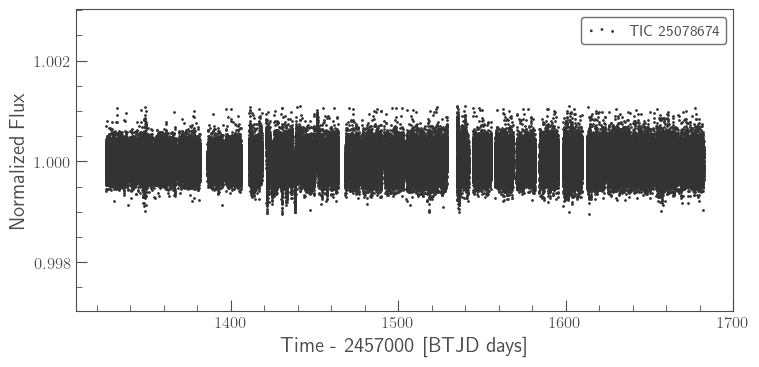

In [8]:
# lcs[0].scatter()

# adding all tics for downloaded data to one array

In [16]:
#opening lists
cooltics = np.load('data/cool_cvz_tics.npy')
addtics = np.load('data/additional_cvz_tics.npy')
#merging lists
all_dled_tics = np.append(cooltics,addtics)
print(len(cooltics),len(addtics),len(all_dled_tics))
#saving as one list
#np.save('data/all_dled_tics',all_dled_tics)

22629 1457 24086


# analyzing stats

max rvar: 215.70187377929688 min rvar: 0.0002333521842956543 0.025075304071023735
this is weird b/c how can it measure longer than its seen?


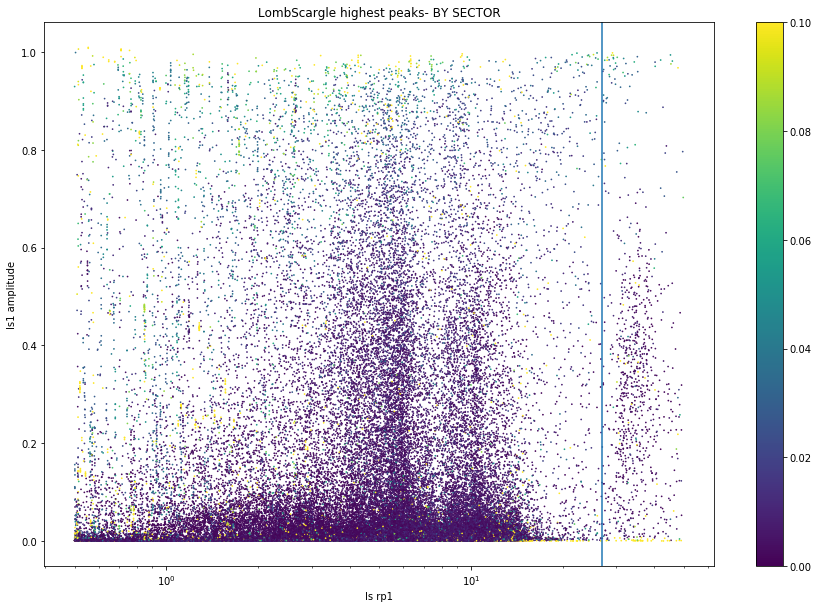

In [66]:
allstats = ascii.read('data/bigstats_by_sector.fits')


plt.figure(figsize=(15,10))
plt.scatter(allstats['ls1'],allstats['lsamp1'],s=.5,c=allstats['rvar'],vmax=0.1,vmin=0.0);
plt.xlabel('ls rp1');
plt.ylabel('ls1 amplitude');
plt.axvline(27) #cadence
plt.xscale('log')
plt.colorbar()
#plt.xlim(0.35,1.05)
#plt.xlim(4,11)
plt.title('LombScargle highest peaks- BY SECTOR');
print('max rvar:',np.max(stats['rvar']),'min rvar:',np.min(stats['rvar']),np.mean(stats['rvar']))
print('this is weird b/c how can it measure longer than its seen?');

In [ ]:
#plt.figure(figsize=(15,10))
plt.scatter(allstats['ls2'],allstats['lsamp2'],s=.5,c=allstats['rvar'],vmax=0.1,vmin=0.0);
plt.xlabel('ls rp1');
plt.ylabel('ls2 amplitude');
plt.axvline(27) #cadence
plt.xscale('log')
plt.colorbar()
#plt.xlim(0.35,1.05)
#plt.xlim(4,11)
plt.title('LombScargle 2nd highest peaks- BY SECTOR');
print('max rvar:',np.max(allstats['rvar']),'min rvar:',np.min(allstats['rvar']),np.mean(allstats['rvar']))
print('this is weird b/c how can it measure longer than its seen?');

# Everything below this line was for Year1s guest speaker

In [ ]:
throw an error

In [ ]:
mq_data = pd.read_csv('INTERN_DATA/McQuillan_data.csv')
mq_data

In [ ]:
sg =mq_data['logg']
m = mq_data['Mass']
rp = mq_data['Prot']
t=mq_data['Teff']
r=mq_data['Rper']
l=mq_data['LPH']
kid = mq_data['KID']
plt.scatter(r,rp,s=1)

In [ ]:
#loading megan bedells gaia/kepler catalog

data = Table.read('data/kepler_dr2_1arcsec.fits', format='fits')
mq = Table([kid,m,t,r,rp,sg,l],names=('kepid','mqmass','mqtemp','mqRper','mqProt','mqlogg','mqLPH'))
joined = join(mq,data,keys='kepid')
#data.colnames
len(joined),len(data),len(mq)

In [ ]:
plt.scatter(joined['radius_val'],joined['mqlogg'],s=1)


In [ ]:
seen = set()
uniq_tics = []
for x in joined['kepid']: #with #mq['kepid']:# they are all unique so that means some didnt match
    if x not in seen:
        uniq_tics.append(x)
        seen.add(x)


print(len(uniq_tics),len(mq['kepid']),len(joined['kepid']),len(data['kepid']))
#print(len(data['kepid'])-len(uniq_tics))#useful if uniq_tics came from running over data['kepid']
print(len(mq['kepid'])-len(uniq_tics))

In [ ]:
#creating & saving as a df
dat = {'ID':joined['kepid'],'RA':joined['ra'],'DEC':joined['dec'],'MASS':joined['mqmass'],'TEMP':joined['mqtemp'],'VARIABILITY':joined['mqRper'],'ROTATION_PERIOD':joined['mqProt'],'SURFACE_GRAVITY':joined['mqlogg'],'RADIUS':joined['radius_val']} 
df = pd.DataFrame(data=dat)
df.to_csv('data/mcquillanwithRADEC.csv',index=False)

In [ ]:
test = pd.read_csv('data/mcquillanwithRADEC.csv')
test